# **Renewables Scenario Generation GAN**

Unofficial implementation in PyTorch 2.

Y. Chen, Y. Wang, D. Kirschen and B. Zhang, "Model-Free Renewable Scenario Generation Using Generative Adversarial Networks," in IEEE Transactions on Power Systems, vol. 33, no. 3, pp. 3265-3275, May 2018, doi: 10.1109/TPWRS.2018.2794541.

Notebook Author: https://github.com/haufjan

### **Import**

In [34]:
import os
import time
import csv
from itertools import chain
import numpy as np
import torch
from torch import nn, tensor
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import scipy
from scipy.signal import welch

### **Random Seeds**

In [35]:
np.random.seed(42)

### **Functions**

In [36]:
#Define function for loading solar data
def load_solar_data(path_data: str, path_labels:str) -> tuple:
    """
    Load and preprocess solar data and labels for GAN training
    """
    with open(f'{path_data}' if path_data.endswith('csv') else f'{path_data}.csv', 'r') as csvfile:
        rows = np.array([row for row in csv.reader(csvfile)], dtype=float)
    #Specify according to time points in your own dataset
    rows = rows[:104832,:]
    print('\nShape rows (data raw):', rows.shape)

    with open(f'{path_labels}' if path_labels.endswith('csv') else f'{path_labels}.csv', 'r') as csvfile:
        labels = np.array([row for row in csv.reader(csvfile)], dtype=int)
    print('\nShape labels (labels raw):', labels.shape)

    #Transform data to conform to GAN image input dimensions (24x24 = 576)
    trX = np.reshape(rows.T,(-1,576))
    print('\nShape trX (data preprocessed):',trX.shape)
    trY = np.tile(labels,(32,1))
    print('\nShape trY (labels preprocessed):', trY.shape)
    m = np.ndarray.max(rows)
    print("\nMax(Solar) =", m)
    trX = trX/m

    return trX, trY, m

In [37]:
#Define One-Hot encoding function
def OneHot(X, n, negative_class=0.):
    """
    Function for encoding ordinal labels into OneHot representation
    """
    X = np.asarray(X).flatten()
    if n is None:
        n = np.max(X) + 1
    Xoh = np.ones((len(X), n)) * negative_class
    for i in range(len(X)):
        m = X[i]
        Xoh[i,m] = 1
    return Xoh

### **Load Data**

In [38]:
#Load and preprocess the data and labels
trX, trY, m = load_solar_data(os.path.join('solar.csv'), os.path.join('solar_label.csv'))

#Find number of unique ordinal labels
events_num = len(np.unique(trY))


Shape rows (data raw): (104832, 32)

Shape labels (labels raw): (182, 1)

Shape trX (data preprocessed): (5824, 576)

Shape trY (labels preprocessed): (5824, 1)

Max(Solar) = 8.13


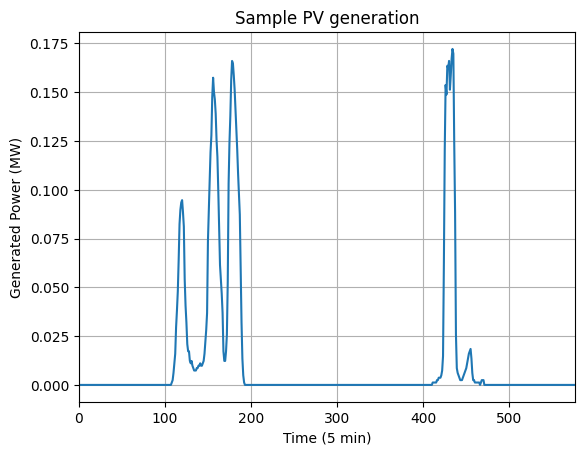

In [39]:
#Plot one sample from the data
fig, ax = plt.subplots()
ax.plot(trX[0,:])
ax.set_xlim(0, trX.shape[-1])
ax.set_xlabel('Time (5 min)')
ax.set_ylabel('Generated Power (MW)')
ax.set_title('Sample PV generation')
ax.grid(True)

### **Device**

In [40]:
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu')

print('Current device:', device)

Current device: cuda


### **Networks**

##### **Generator**

In [41]:
class Generator(nn.Module):
    def __init__(self, batch_size, dim_y, dim_z, dim_W1, dim_W2, dim_W3, dim_channel):
        super().__init__()
        #Parameters
        self.batch_size = batch_size
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.dim_W1 = dim_W1
        self.dim_W2 = dim_W2
        self.dim_W3 = dim_W3
        self.dim_channel = dim_channel

        #Layers
        self.layer1 = nn.Sequential(nn.Linear(dim_z + dim_y, dim_W1, bias=False),
                                    nn.BatchNorm1d(dim_W1, eps=1e-8),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(dim_W1 + dim_y, dim_W2*6*6, bias=False),
                                    nn.BatchNorm1d(dim_W2*6*6, eps=1e-8),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(in_channels=dim_W2 + dim_y, out_channels=dim_W3, kernel_size=5, stride=2, padding=2, output_padding=1),
                                    nn.BatchNorm2d(dim_W3, eps=1e-8),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(in_channels=dim_W3 + dim_y, out_channels=dim_channel, kernel_size=5, stride=2, padding=2, output_padding=1),
                                    nn.BatchNorm2d(dim_channel, eps=1e-8))

    def forward(self, z, y):
        yb = torch.reshape(y, (self.batch_size, self.dim_y, 1, 1))
        z = torch.cat((z, y), 1)
        h1 = self.layer1(z)
        h1 = torch.cat((h1, y), 1)
        h2 = self.layer2(h1)
        h2 = torch.reshape(h2, (self.batch_size, self.dim_W2, 6, 6))
        h2 = torch.cat((h2, torch.mul(yb, torch.ones((self.batch_size, self.dim_y, 6, 6), dtype=torch.float32, device=device))), 1)
        n = torch.mul(yb, torch.ones((self.batch_size, self.dim_y, 6, 6), dtype=torch.float32, device=device))
        h3 = self.layer3(h2)
        h3 = torch.cat((h3, torch.mul(yb, torch.ones((self.batch_size, self.dim_y, 12, 12), dtype=torch.float32, device=device))), 1)
        h4 = self.layer4(h3)

        return h4

##### **Discriminator**

In [42]:
class Discriminator(nn.Module):
    def __init__(self, batch_size, dim_y, dim_z, dim_W1, dim_W2, dim_W3, dim_channel):
        super().__init__()
        #Parameters
        self.batch_size = batch_size
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.dim_W1 = dim_W1
        self.dim_W2 = dim_W2
        self.dim_W3 = dim_W3
        self.dim_channel = dim_channel

        #Layers
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=dim_channel + dim_y, out_channels=dim_W3, kernel_size=5, stride=2, padding=2),
                                    nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=dim_W3 + dim_y, out_channels=dim_W2, kernel_size=5, stride=2, padding=2),
                                    nn.BatchNorm2d(dim_W2, eps=1e-8),
                                    nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.layer3 = nn.Sequential(nn.Linear(dim_W2*6*6 + dim_y, dim_W1, bias=False),
                                    nn.BatchNorm1d(dim_W1, eps=1e-8),
                                    nn.LeakyReLU(negative_slope=0.2, inplace=True))

    def forward(self, image, y):
        yb = torch.reshape(y, (self.batch_size, self.dim_y, 1, 1))
        x = torch.cat((image, torch.mul(yb, torch.ones((self.batch_size, self.dim_y, 24, 24), dtype=torch.float32, device=device))), 1)
        h1 = self.layer1(x)
        h1 = torch.cat((h1, torch.mul(yb, torch.ones((self.batch_size, self.dim_y, 12, 12), dtype=torch.float32, device=device))), 1)
        h2 = self.layer2(h1)
        h2 = torch.reshape(h2, (self.batch_size, -1))
        h2 = torch.cat((h2, y), 1)
        h3 = self.layer3(h2)

        return h3

### **Loss Functions**

In [43]:
def generator_cost(raw_gen2):
    return -torch.mean(raw_gen2)

In [44]:
def discriminator_cost(raw_real2, raw_gen2):
    return torch.sum(raw_gen2) - torch.sum(raw_real2)

### **GAN**

In [45]:
class GAN(nn.Module):
    def __init__(self,
                 epochs: int = 10,
                 batch_size: int = 32,
                 image_shape: list = [1, 24, 24],
                 dim_y: int = 6,
                 dim_z: int = 100,
                 dim_W1: int = 1024,
                 dim_W2: int = 128,
                 dim_W3: int = 64,
                 dim_channel: int = 1,
                 learning_rate: float = 1e-4):

        super().__init__()
        #Parameters
        self.epochs = epochs
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.dim_W1 = dim_W1
        self.dim_W2 = dim_W2
        self.dim_W3 = dim_W3
        self.dim_channel = dim_channel
        self.learning_rate = learning_rate
        self.normal = (0, 0.1)

        #Networks
        self.generator = Generator(batch_size, dim_y, dim_z, dim_W1, dim_W2, dim_W3, dim_channel)
        self.discriminator = Discriminator(batch_size, dim_y, dim_z, dim_W1, dim_W2, dim_W3, dim_channel)

        #Loss functions
        self.generator_loss = generator_cost
        self.discriminator_loss = discriminator_cost

        #Optimizers
        self.optimizer_g = torch.optim.RMSprop(list(self.generator.parameters()), learning_rate)
        self.optimizer_d = torch.optim.RMSprop(list(self.discriminator.parameters()), learning_rate)

        #Initialization of weights
        for weights in chain(self.generator.parameters(), self.discriminator.parameters()):
            torch.nn.init.normal_(weights, mean=0.0, std=0.02)

        #Auxiliary
        self.fitting_time = None

    def fit(self, x, y):
        self.fitting_time = time.time()
        iterations = 0

        #Control balance of training discriminator vs generator
        k = 4

        p_real = []
        p_fake = []
        discrim_loss = []
        gen_loss = []

        #Transform labels into OneHot representation
        y_oh = OneHot(y, n=self.dim_y)

        for epoch in range(self.epochs):
            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('Epoch:', epoch + 1)

            # index = np.arange(len(y))
            # np.random.shuffle(index)
            # x = x[index]
            # y = y[index]
            # y2 = OneHot(y, n=self.dim_y)

            # for start, end in zip(range(0, len(y), self.batch_size), range(self.batch_size, len(y), self.batch_size)):
            #     xs = x [start:end].reshape([-1, 1, 24, 24])
            #     ys = y2[start:end]

            #     zs = np.random.normal(self.normal[0], self.normal[1], size=(self.batch_size, self.dim_z)).astype(np.float32)

            #     xs = tensor(xs, dtype=torch.float32, device=device)
            #     ys = tensor(ys, dtype=torch.float32, device=device)
            #     zs = tensor(zs, dtype=torch.float32, device=device)

            z = np.random.normal(self.normal[0], self.normal[1], size=(len(y), self.dim_z))

            ds_train = TensorDataset(tensor(x, dtype=torch.float32, device=device),
                                     tensor(y_oh, dtype=torch.float32, device=device),
                                     tensor(z, dtype=torch.float32, device=device))

            batches_train = DataLoader(ds_train, batch_size=self.batch_size, shuffle=True, drop_last=True)

            for xs, ys, zs in batches_train:
                # xs = torch.reshape(xs, (-1, 1, 24, 24))
                xs = torch.reshape(xs, [-1] + self.image_shape)

                self.train()
                if iterations % k == 0:
                    self.optimizer_g.zero_grad()

                    h4 = self.generator(zs, ys)
                    image_gen = nn.Sigmoid()(h4)
                    raw_gen2 = self.discriminator(image_gen, ys)
                    p_gen_val = torch.mean(raw_gen2)

                    gen_loss_val = self.generator_loss(raw_gen2)

                    raw_real2 = self.discriminator(xs, ys)
                    p_real_val = torch.mean(raw_real2)

                    discrim_loss_val = self.discriminator_loss(raw_real2, raw_gen2)

                    gen_loss_val.backward()
                    self.optimizer_g.step()
                else:
                    self.optimizer_d.zero_grad()

                    h4 = self.generator(zs, ys)
                    image_gen = nn.Sigmoid()(h4)
                    raw_gen2 = self.discriminator(image_gen, ys)
                    p_gen_val = torch.mean(raw_gen2)

                    gen_loss_val = self.generator_loss(raw_gen2)

                    raw_real2 = self.discriminator(xs, ys)
                    p_real_val = torch.mean(raw_real2)

                    discrim_loss_val = self.discriminator_loss(raw_real2, raw_gen2)

                    discrim_loss_val.backward()
                    self.optimizer_d.step()

                p_real.append(p_real_val.cpu().item())
                p_fake.append(p_gen_val.cpu().item())
                discrim_loss.append(discrim_loss_val.cpu().item())
                gen_loss.append(gen_loss_val.cpu().item())

                if iterations % 1000 == 0:
                    print('Iterations',
                          iterations,
                          '| Average P(real):', f'{p_real_val.cpu().item():12.9f}',
                          '| Average P(fake):', f'{p_gen_val.cpu().item():12.9f}',
                          '| Discriminator loss:', f'{discrim_loss_val.cpu().item():12.9f}',
                          '| Generator loss:', f'{gen_loss_val.cpu().item():12.9f}')

                    # self.eval()
                    # with torch.no_grad():
                    #     y_np_sample = OneHot(np.random.randint(events_num, size=[self.batch_size]), n=events_num)
                    #     z_np_sample = np.random.normal(self.normal[0], self.normal[1], size=[self.batch_size, self.dim_z]).astype(np.float32)

                    #     y_np_sample = tensor(y_np_sample, dtype=torch.float32, device=device)
                    #     z_np_sample = tensor(z_np_sample, dtype=torch.float32, device=device)

                    #     generated_samples = nn.Sigmoid()(self.generator(z_np_sample, y_np_sample))

                    #     generated_samples = generated_samples.reshape([-1, 576])

                    #     generated_samples = generated_samples * max_value

                        # with open(data_saving_path + '%s.csv' %iterations, 'w') as csvfile:
                        #     # spamwriter = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
                        #     writer = csv.writer(csvfile)
                        #     writer.writerows(generated_samples.cpu().detach().numpy())
                        #     csvfile.close()

                iterations += 1

        self.fitting_time = np.round(time.time() - self.fitting_time, 3)
        print('\nElapsed Training Time: ' + time.strftime('%Hh %Mmin %Ss', time.gmtime(self.fitting_time)))

        #Plotting
        # print('P_real', p_real)
        # print('P_fake', p_fake)

        fig, ax = plt.subplots()
        ax.plot(p_real, label='real')
        ax.plot(p_fake, label='fake')
        ax.legend()
        ax.set_xlim(0, len(p_real))
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Wasserstein Distance')
        ax.grid(True)
        fig.show()

        fig, ax = plt.subplots()
        ax.plot(discrim_loss)
        ax.set_xlim(0, len(discrim_loss))
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Discriminator Loss')
        ax.grid(True)
        fig.show()

    def predict(self):
        self.eval()
        with torch.no_grad():
            generated_labels = np.random.randint(self.dim_y, size=(self.batch_size,))
            zs = np.random.normal(self.normal[0], self.normal[1], size=[self.batch_size, self.dim_z]).astype(np.float32)

            y_np_sample = tensor(OneHot(generated_labels, n=self.dim_y), dtype=torch.int8, device=device)
            zs = tensor(zs, dtype=torch.float32, device=device)

            generated_samples = nn.Sigmoid()(self.generator(zs, y_np_sample))

        #Image shape 24x24 = 576
        generated_samples = generated_samples.reshape([-1, 576])

        return generated_samples.cpu().detach().numpy(), generated_labels

        # with open(f'{path_data}' if path_data.endswith('csv') else f'{path_data}.csv', 'w') as csvfile:
        #     writer = csv.writer(csvfile)
        #     writer.writerows(generated_samples.cpu().detach().numpy())
        #     csvfile.close()

        # with open(f'{path_labels}' if path_labels.endswith('csv') else f'{path_labels}.csv', 'w') as csvfile:
        #     writer = csv.writer(csvfile)
        #     writer.writerows(y_np_sample.cpu().detach().numpy())
        #     csvfile.close()

### **Instantiate GAN Model**

In [46]:
#Create GAN model instance with specified parameters
model = GAN(epochs=400,
            dim_y=events_num,
            learning_rate=1e-3).to(device)

### **Train GAN Model**

Iterations 0 | Average P(real):  0.009256576 | Average P(fake):  0.009255607 | Discriminator loss: -0.031768799 | Generator loss: -0.009255607
Iterations 1000 | Average P(real):  0.181804925 | Average P(fake):  0.059146922 | Discriminator loss: -4019.257324219 | Generator loss: -0.059146922
Iterations 2000 | Average P(real):  0.315278351 | Average P(fake):  0.098077446 | Discriminator loss: -7117.239257812 | Generator loss: -0.098077446
Iterations 3000 | Average P(real):  0.472585678 | Average P(fake):  0.135760143 | Discriminator loss: -11037.099609375 | Generator loss: -0.135760143
Iterations 4000 | Average P(real):  0.638562679 | Average P(fake):  0.194111839 | Discriminator loss: -14563.765625000 | Generator loss: -0.194111839
Iterations 5000 | Average P(real):  0.775180519 | Average P(fake):  0.220422626 | Discriminator loss: -18178.306640625 | Generator loss: -0.220422626
Iterations 6000 | Average P(real):  0.989524961 | Average P(fake):  0.401940078 | Discriminator loss: -19253.

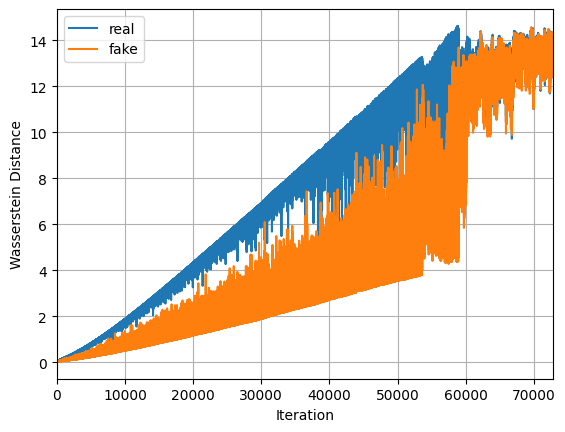

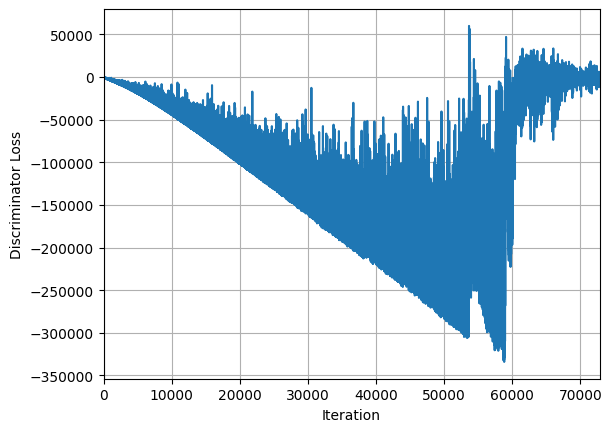

In [47]:
#Start training
model.fit(trX, trY)

### **Generate Data**

In [48]:
#Sample a set of labels and generate data
data_gen, labels_sampled = model.predict()

#Rescaling
data_real = trX*m
data_gen = data_gen*m

### **Evaluation**

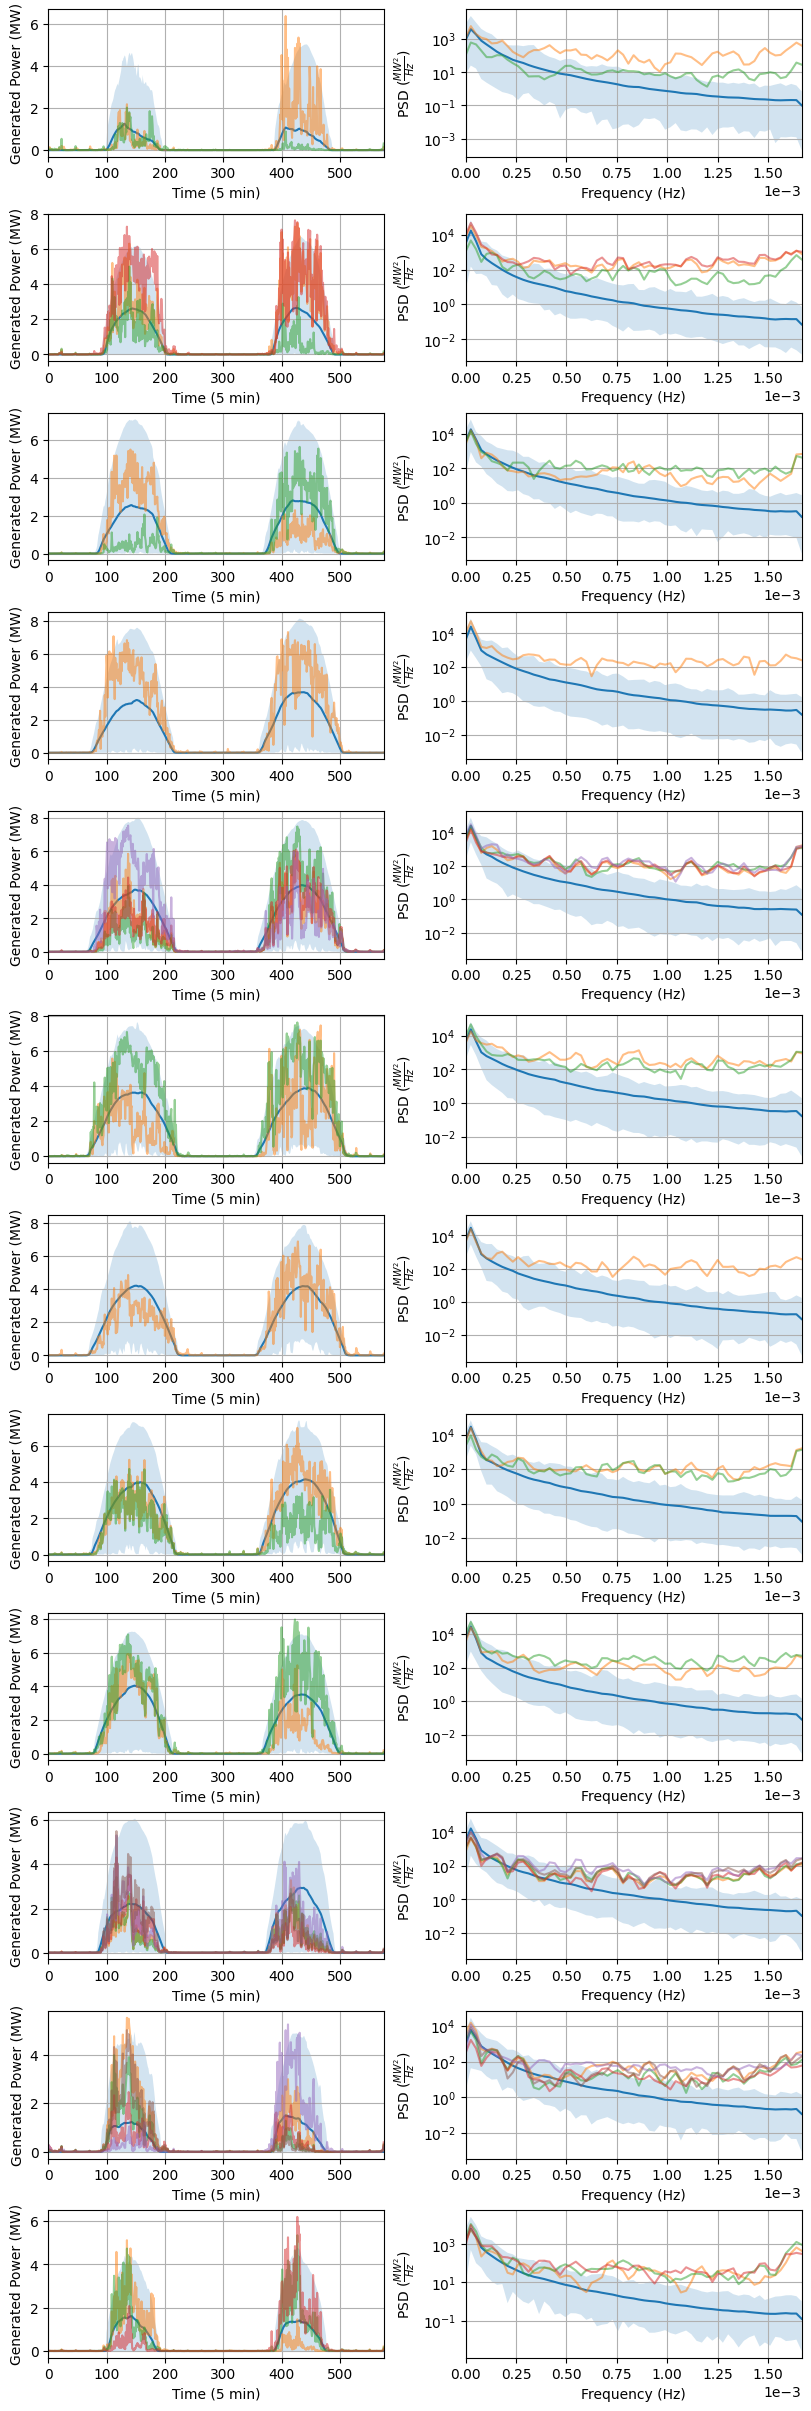

In [50]:
#Find unique ordinal labels within samples
labels_unique = np.unique(labels_sampled)

#Sampling frequency of 5 min resolution in Hz
fs = 1/(60*5)

fig, ax = plt.subplots(len(labels_unique), 2, figsize=(8, 2*len(labels_unique)), layout='constrained')
for i, label in enumerate(labels_unique):
    #Get indices to organize by ordinal labels
    indices_real, _ = np.where(trY == label)
    indices_gen = np.where(labels_sampled == label)

    #Left column
    ax[i,0].fill_between(np.arange(0, data_real.shape[-1]), np.max(data_real[indices_real], 0), np.min(data_real[indices_real], 0), alpha=0.2)
    ax[i,0].plot(np.mean(data_real[indices_real], 0))
    ax[i,0].plot(data_gen[indices_gen].transpose(), alpha=0.5)
    ax[i,0].set_xlabel('Time (5 min)')
    ax[i,0].set_ylabel('Generated Power (MW)')
    ax[i,0].set_xlim(0,data_gen.shape[-1])
    ax[i,0].grid(True)

    #Right column
    f_real, Pxx_den_real = welch(data_real[indices_real,:], fs, nperseg=128)
    f_gen, Pxx_den_gen = welch(data_gen[indices_gen[0],:], fs, nperseg=128)
    ax[i,1].semilogy(f_real, np.mean(Pxx_den_real, 0))
    ax[i,1].fill_between(f_real, np.max(Pxx_den_real, 0), np.min(Pxx_den_real, 0), alpha=0.2)
    ax[i,1].semilogy(f_gen, Pxx_den_gen.transpose(), alpha=0.5)
    ax[i,1].set_xlim(0,max(f_real))
    ax[i,1].ticklabel_format(axis='x', style='sci', scilimits=(0,max(f_real)))
    ax[i,1].set_xlabel('Frequency (Hz)')
    ax[i,1].set_ylabel(r'PSD ($\frac{MW^2}{Hz}$)')
    ax[i,1].grid(True)

# fig.savefig('generated_data_solar.png', bbox_inches='tight')